<h1>K Nearest Neighbors<h1>
<h3>Load Data and Import Modules<h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('full_mag_insulators.csv')
df_filtered = pd.read_csv('Materials_With_AtLeast_OneMagneticElement.csv')

In [15]:
# Drop rows with missing values in features or target
df = df.dropna(subset=['ordering'])
df_filtered = df_filtered.dropna(subset=['ordering'])

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay



<h4>Use same features as determined by the logistic regression analysis, using the same one-hot encoding and frequency encoding.<h4>

In [20]:
# Separate features and target
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
extra_cols = ['is_gap_direct', 'is_stable']
#['symmetry', 'elements', 'chemsys', 'formula', 'composition', 'structure']
categorical_cols = ['symmetry', 'elements', 'chemsys']

# Prepare X and y
X = df[numerical_columns + extra_cols + categorical_cols]
y = df['ordering']

# Split first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Frequency encode high-cardinality categorical columns
for col in categorical_cols:
    freq = X_train[col].value_counts()
    X_train[col + '_freq'] = X_train[col].map(freq)
    X_test[col + '_freq'] = X_test[col].map(freq).fillna(0)

# Drop original high-cardinality columns
X_train = X_train.drop(columns=categorical_cols)
X_test = X_test.drop(columns=categorical_cols)

# One-hot encode the last two columns
X_train = pd.get_dummies(X_train, columns=extra_cols)
X_test = pd.get_dummies(X_test, columns=extra_cols)

# Align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

4-fold cross-validated accuracy scores: [0.73747618 0.74338684 0.73927649 0.73549742]
Mean accuracy: 0.739
Classification Report:
              precision    recall  f1-score   support

         AFM       0.31      0.17      0.22       683
          FM       0.67      0.74      0.71     11338
         FiM       0.46      0.29      0.36      2269
          NM       0.83      0.83      0.83     16671

    accuracy                           0.75     30961
   macro avg       0.57      0.51      0.53     30961
weighted avg       0.74      0.75      0.74     30961



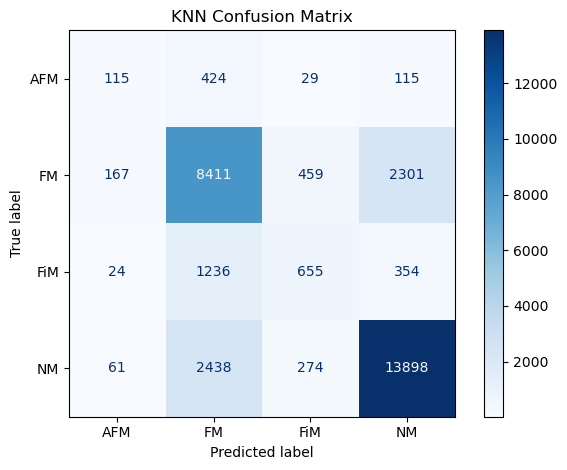

In [21]:
# Initialize the KNN classifier (e.g., with k=5)
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
knn.fit(X_train, y_train)

# 4-fold cross-validation on the training set
scores = cross_val_score(knn, X_train, y_train, cv=4, scoring='accuracy')

print(f"4-fold cross-validated accuracy scores: {scores}")
print(f"Mean accuracy: {scores.mean():.3f}")

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("KNN Confusion Matrix")
plt.tight_layout()
plt.show()

<h4> A much higher accuracy is achieved with kNN compared to Logistic Regression, but still lower than Random Forests.<h4>
<h4> Below is the same analysis but for the same filtered data set, leading to reduced accuracy.<h4>

In [10]:
# Separate features and target
numerical_columns = df_filtered.select_dtypes(include=[np.number]).columns.tolist()
#categorical columns with low cardinality
extra_cols = ['is_gap_direct', 'is_stable']
selected_cols = numerical_columns + [col for col in extra_cols if col in df_filtered.columns]
X = df_filtered[selected_cols]
y = df_filtered['ordering']


# Convert categorical features to numeric using one-hot encoding
X_encoded = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

4-fold cross-validated accuracy scores: [0.69533983 0.69165462 0.69173353 0.69066057]
Mean accuracy: 0.692
Classification Report:
              precision    recall  f1-score   support

         AFM       0.29      0.15      0.20       672
          FM       0.69      0.78      0.74     10212
         FiM       0.45      0.30      0.36      2180
          NM       0.77      0.74      0.75      8373

    accuracy                           0.70     21437
   macro avg       0.55      0.49      0.51     21437
weighted avg       0.68      0.70      0.69     21437



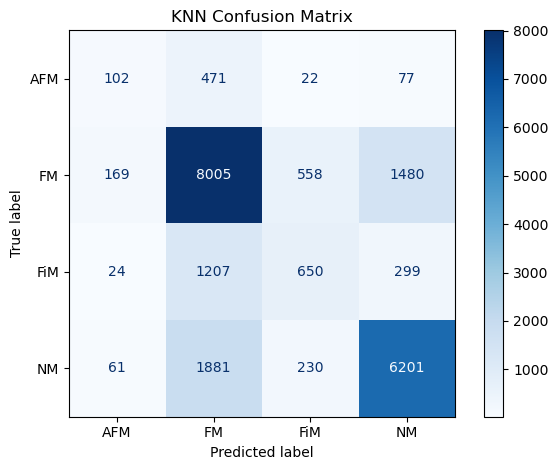

In [11]:
# Initialize the KNN classifier (e.g., with k=5)
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
knn.fit(X_train_scaled, y_train)

# 4-fold cross-validation on the training set
scores = cross_val_score(knn, X_train_scaled, y_train, cv=4, scoring='accuracy')

print(f"4-fold cross-validated accuracy scores: {scores}")
print(f"Mean accuracy: {scores.mean():.3f}")

# Predict on the test set
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("KNN Confusion Matrix")
plt.tight_layout()
plt.show()